--- Implementation Shortfall Statistics (200 MC Runs) ---
TWAP:
  Mean IS: -2.1631
  Std Dev IS: 599.6298
Front-loaded (λ=1.5):
  Mean IS: -1.6963
  Std Dev IS: 497.1179
Heuristic (α=2.0):
  Mean IS: -1.6310
  Std Dev IS: 519.7088


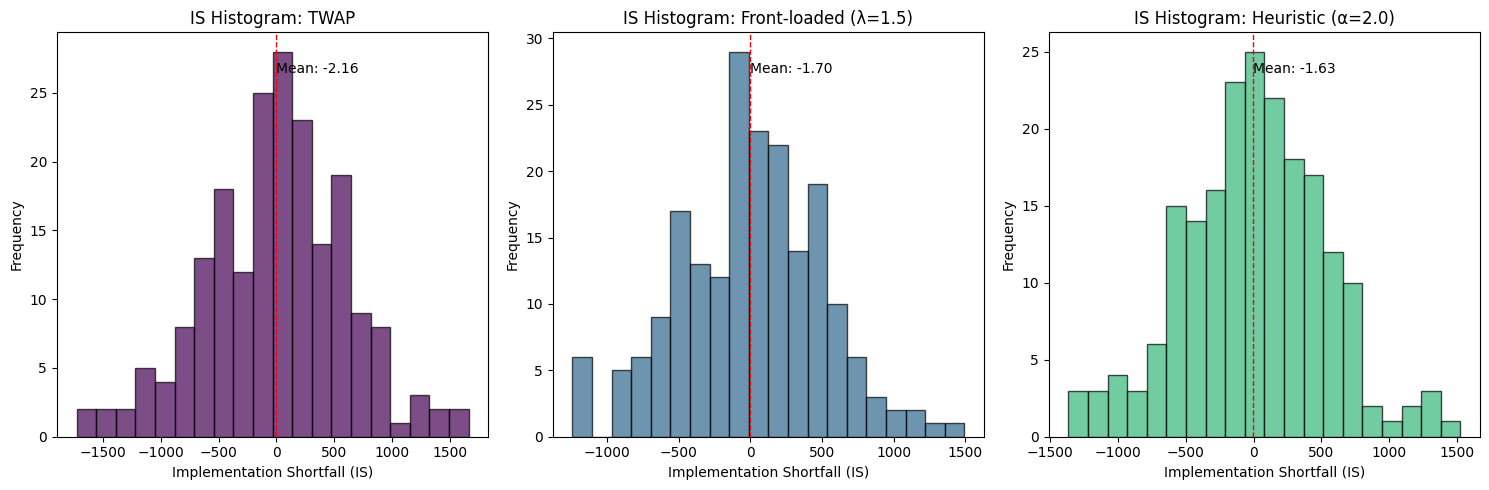

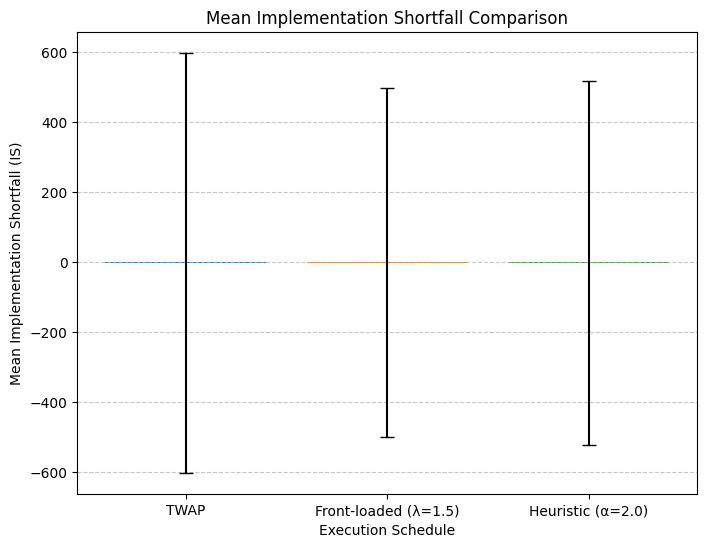

In [38]:
# --- Optimal Execution Comparison: TWAP vs Front- loaded vs Heuristic ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Key Parameters for Data Generation ---

np.random.seed(42)
X_total = 1000
eta = 10 ** (-5)
gamma = 10 ** (-4)

# --- price Process Simulation ---

n_simulations = 1
n_steps = 252
dt = 1.0 / n_steps

mu = 0
sigma = 0.01
P0 = 100
P = np.zeros((n_steps, n_simulations))
dZ = np.random.standard_normal(size = (n_steps, n_simulations))

for i in range(n_simulations):
    P[0, i] = P0
    for t in range(1, n_steps):
        P[t, i] = P[t - 1, i] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * dZ[t, i])

# --- Monte Carlo Simulation Parameters ---

n_mc_simulations = 200
time_steps = np.arange(1, n_steps + 1) * dt

# --- Schedule Generation Functions (xk) ---

def twap_schedule(X_total, n_steps):
    """TWAP: xk = X_total / n"""
    return np.ones(n_steps) * (X_total / n_steps)

def front_loaded_schedule(X_total, n_steps, lambda_param = 1.5):
    """Front-loaded: xk ∝ e^(-lambda * tk)"""
    t_mid = (np.arange(1, n_steps + 1) - 0.5) / n_steps
    weights = np.exp(-lambda_param * t_mid)
    x_k = X_total * (weights / np.sum(weights))
    return x_k

def heuristic_schedule(X_total, n_steps, alpha = 2.0):
    """Heuristic xk ∝ 1 / (1 + alpha * tk)"""
    t_mid = (np.arange(1, n_steps + 1) - 0.5) / n_steps
    weights = 1.0 / (1.0 + alpha * t_mid)
    x_k = X_total * (weights / np.sum(weights))
    return x_k

# --- Cost and IS Calculation Function ---

def calculate_cost_and_is(P_series, xk_schedule, P0, eta, gamma, X_total):
    X_bar = np.cumsum(xk_schedule)
    permanent_impact_k = eta * X_bar
    temporary_impact_k = gamma * xk_schedule
    P_exec_k = P_series + permanent_impact_k + 0.5 * temporary_impact_k
    total_cost = np.sum(xk_schedule * P_exec_k)
    is_cost = total_cost - X_total * P0
    return is_cost

schedules = {
    "TWAP": twap_schedule(X_total, n_steps),
    "Front-loaded (\u03BB=1.5)": front_loaded_schedule(X_total, n_steps, lambda_param=1.5),
    "Heuristic (\u03B1=2.0)": heuristic_schedule(X_total, n_steps, alpha=2.0) # Using alpha=2.0 for a typical decay
}

# --- Monte Carlo Simulation ---

is_results = {name: np.zeros(n_mc_simulations) for name in schedules.keys()}

for mc_run in range(n_mc_simulations):
    
    P_series = np.zeros(n_steps)
    dZ = np.random.standard_normal(size=n_steps)
    P_series[0] = P0
    for t in range(1, n_steps):
        P_series[t] = P_series[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * dZ[t])
        
    for name, xk in schedules.items():
        is_results[name][mc_run] = calculate_cost_and_is(P_series, xk, P0, eta, gamma, X_total)

mean_is = {name: np.mean(is_results[name]) for name in is_results.keys()}
std_is = {name: np.std(is_results[name]) for name in is_results.keys()}

print("--- Implementation Shortfall Statistics (200 MC Runs) ---")
for name in mean_is.keys():
    print(f"{name}:\n  Mean IS: {mean_is[name]:.4f}\n  Std Dev IS: {std_is[name]:.4f}")

# --- Data Visualisation ---

plt.figure(figsize=(15, 5))
for i, (name, results) in enumerate(is_results.items()):
    plt.subplot(1, 3, i + 1)
    plt.hist(results, bins=20, edgecolor='black', alpha=0.7, color=plt.cm.viridis(i/len(is_results)))
    plt.title(f'IS Histogram: {name}')
    plt.xlabel('Implementation Shortfall (IS)')
    plt.ylabel('Frequency')
    plt.axvline(mean_is[name], color='red', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(mean_is[name]*1.05, max_ylim*0.9, f'Mean: {mean_is[name]:.2f}')

plt.tight_layout()
plt.show();


names = list(mean_is.keys())
means = [mean_is[name] for name in names]
stds = [std_is[name] for name in names]

plt.figure(figsize=(8, 6))
plt.bar(names, means, yerr=stds, capsize=5, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Mean Implementation Shortfall Comparison')
plt.ylabel('Mean Implementation Shortfall (IS)')
plt.xlabel('Execution Schedule')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show();